# Introduction
This note book applies time series analysis to random number sequence. The idea is to see if ML model can be effectively used to predict yet-to-come random draw!

In [50]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt

In [51]:
tf.__version__

'2.3.0'

## UDFs

Functions for various steps in the model:

In [52]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end], series_num[start:end], format)

    else:
        plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


# The following function, takes a series along with other parameters and creates TF dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    # dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

Set the paramters for the data pre-processing. These are used in TensorFlow windowing steps.

In [117]:
# Parameters
window_size = 100
batch_size = 32
shuffle_buffer_size = 1000

Generate sequence of random integers and create training and validation sets:

In [118]:
L = 10000
time = np.arange(L)
# Define the split time
split_time = 9500

random.seed(7)
series = np.array(random.choices(range(10), k=L))

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [119]:
dataset = windowed_dataset(x_train, window_size, batch_size,shuffle_buffer_size)

In [120]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 100)
shape of second element: (32,)


# Naive model
Generate random numbers as prediction value and evaluate the performance:

In [127]:
# get the length of the validation seq and generate seq of random integers of the same length using different seed
L = len(x_valid)
print(L)
random.seed(10)
yhat_random = np.array(random.choices(range(10), k=L))

500


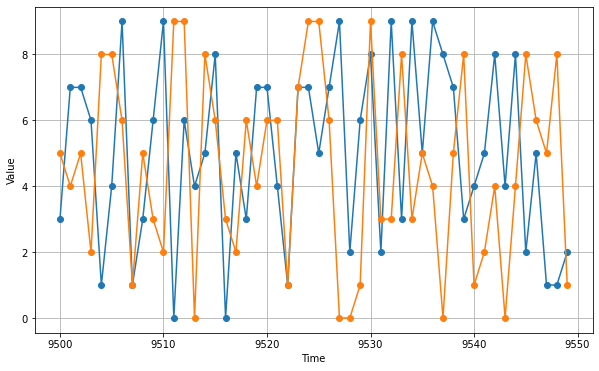

In [128]:
# Overlay the results with the validation set
plot_series(time_valid, (x_valid, yhat_random),format="-o", start=0, end=50)

In [129]:
# count how many time random prediction matches the underlying sequence:
print(f'Count of the matching between two sequences: {np.sum(yhat_random == x_valid)}')
print(f'Fraction of the matching between two sequences: {round(np.sum(yhat_random == x_valid) / len(x_valid),3)}')

Count of the matching between two sequences: 40
Fraction of the matching between two sequences: 0.08


In [130]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, yhat_random).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, yhat_random).numpy())

16
3


## Build and compile the model

Next, you will build the single layer neural network. This will just be a one-unit [Dense](https://keras.io/api/layers/core_layers/dense/) layer as shown below.

In [131]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[ 0.22885779],
       [ 0.12938485],
       [-0.13491303],
       [-0.08367549],
       [-0.22216532],
       [ 0.05449578],
       [ 0.1987122 ],
       [ 0.14205927],
       [-0.21680178],
       [-0.10554563],
       [ 0.09124345],
       [-0.00750631],
       [ 0.11804578],
       [ 0.0861485 ],
       [-0.09994987],
       [-0.00791338],
       [ 0.05806702],
       [-0.01884967],
       [-0.18933704],
       [-0.15102278],
       [ 0.21189085],
       [-0.05754752],
       [-0.0404693 ],
       [ 0.04403698],
       [-0.21652116],
       [ 0.17794684],
       [ 0.06112772],
       [ 0.07854137],
       [ 0.02850452],
       [-0.12730466],
       [-0.18331574],
       [-0.06800045],
       [ 0.23564425],
       [ 0.04640284],
       [ 0.05145067],
       [-0.08209057],
       [-0.19023257],
       [-0.03411183],
       [-0.02835336],
       [ 0.06381875],
       [-0.09647009],
       [ 0.02474707],
       [ 0.16007507],
       [-0.16597107],
       [ 0.242

In [132]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [133]:
model.fit(dataset,epochs=100)

Epoch 1/100
294/294 [==============================] - 2s 8ms/step - loss: 27.1062
Epoch 2/100
294/294 [==============================] - 2s 8ms/step - loss: 23.1972
Epoch 3/100
294/294 [==============================] - 2s 8ms/step - loss: 21.8025
Epoch 4/100
294/294 [==============================] - 2s 8ms/step - loss: 20.5397
Epoch 5/100
294/294 [==============================] - 2s 8ms/step - loss: 19.3962
Epoch 6/100
294/294 [==============================] - 3s 11ms/step - loss: 18.3606
Epoch 7/100
294/294 [==============================] - 4s 12ms/step - loss: 17.4227
Epoch 8/100
294/294 [==============================] - 3s 10ms/step - loss: 16.5732
Epoch 9/100
294/294 [==============================] - 3s 10ms/step - loss: 15.8036
Epoch 10/100
294/294 [==============================] - 3s 9ms/step - loss: 15.1064
Epoch 11/100
294/294 [==============================] - 2s 8ms/step - loss: 14.4747
Epoch 12/100
294/294 [==============================] - 2s 8ms/step - loss: 13.90

294/294 [==============================] - 2s 8ms/step - loss: 8.3170
Epoch 100/100
294/294 [==============================] - 2s 8ms/step - loss: 8.3168


In [134]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.01330081],
       [ 0.00063099],
       [ 0.00956393],
       [ 0.01691513],
       [-0.00405364],
       [ 0.01643663],
       [ 0.00730844],
       [ 0.00034941],
       [ 0.00956978],
       [ 0.02481993],
       [ 0.00224442],
       [ 0.02270467],
       [ 0.00583207],
       [ 0.01868231],
       [ 0.01922304],
       [-0.00306423],
       [ 0.01674444],
       [-0.01456529],
       [ 0.01499869],
       [ 0.01902609],
       [-0.01027579],
       [ 0.02888958],
       [ 0.0007442 ],
       [ 0.002157  ],
       [ 0.0110763 ],
       [-0.00593292],
       [ 0.01928378],
       [ 0.01180403],
       [ 0.00320514],
       [ 0.02151784],
       [-0.00465043],
       [ 0.02555589],
       [ 0.02106906],
       [ 0.01562781],
       [ 0.02080203],
       [ 0.0046527 ],
       [ 0.0181698 ],
       [-0.00134944],
       [-0.0143496 ],
       [ 0.00532194],
       [ 0.01859636],
       [ 0.00230236],
       [-0.00221162],
       [ 0.01395768],
       [ 0.010594

In [142]:
# Sample model prediction
print(f'model prediction: {model.predict(series[2000:2100][np.newaxis])}')

model prediction: [[4.350315]]


In [136]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

length of the forecast list: 500
shape of the validation set: (500,)


In [137]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
results = [int(round(x)) for x in results]

shape after converting to numpy array: (500, 1, 1)
shape after squeezing: (500,)


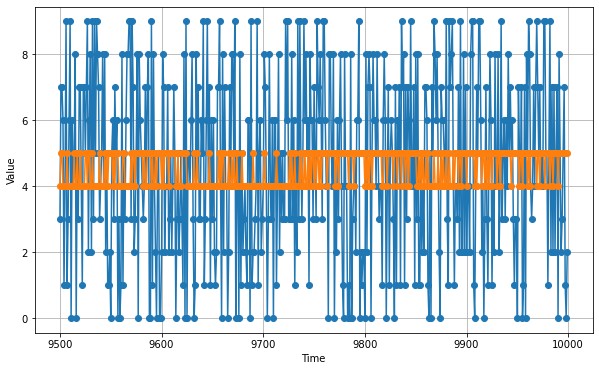

In [140]:
# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results),format="-o", start=0, end=500)

In [139]:
# count how many time random prediction matches the underlying sequence:
print(f'Count of the matching between two sequences: {np.sum(results == x_valid)}')
print(f'Fraction of the matching between two sequences: {round(np.sum(results == x_valid) / len(x_valid),3)}')

Count of the matching between two sequences: 60
Fraction of the matching between two sequences: 0.12


In [143]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

7
2
